# Particles interacting in a Lennard Jones potential

In this notebook, we'll simulate particles interacting in a Lennard-Jones potential. The steps are going to be very similar to those we followed for the ideal gas simulation, so I really recommend
you go see [this video](https://www.youtube.com/watch?v=Gn5QoDCDGgo&t=12s) first. 

The only difference is that we'll use **periodic boundary conditions** and we have to change our method for integrating the equations of motion since there are now **forces** between the particles. 

## Assumptions

* The particles are represented by circles that all have the same radius and mass. 
* The particles start at random positions and with random velocities. 
* The particles can only interact with each other through the Lennard-Jones potential. 
* We use periodic boundary conditions: if a particle leaves the box, it appears on the other side. 


## Algorithm 
The idea behind the algorithm to run the simulation is simple: 

* Fix the number of particles, the size of the container and length of simulation.
* Initialize the positions and velocities at time $t=0$. 
* At each time step $t$, find the forces acting on all the particles. 
* Numerically integrate the equations of motion to evolve the positions and velocities from $t \to t+ \Delta t$.



## 1 The Lennard-Jones potential

The Lennard-Jones (LJ) potential between two particles is given by: 

$$U_{LJ}(\vec r) = 4 \epsilon \left[ \left( \frac{\sigma}{r}\right)^{12} - \left( \frac{\sigma}{r}\right)^{6} \right],$$
where $r = |\vec r|$ is the distance between the two particles. We will use reduced units $\epsilon \to 1$, $\sigma \to 1$ , i.e work in units of $\epsilon$ and $\sigma$. Since $U_{LJ}$ rapidly approaches $0$ as $r$ increases, we usually introduce a cutoff $r_c$ such that $U_{LJ}(r > r_c) = 0.$ For this simulation, we'll take $r_c = 2.5$ units of $\sigma$. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import matplotlib.animation as animation
from IPython.display import HTML
plt.rcParams['figure.dpi'] = 300  
plt.rcParams['animation.embed_limit'] = 30

Let's plot the LJ potential for a range of values $r$ to see what is going on. 

Text(0.5, 1.0, 'Lennard-Jones potential')

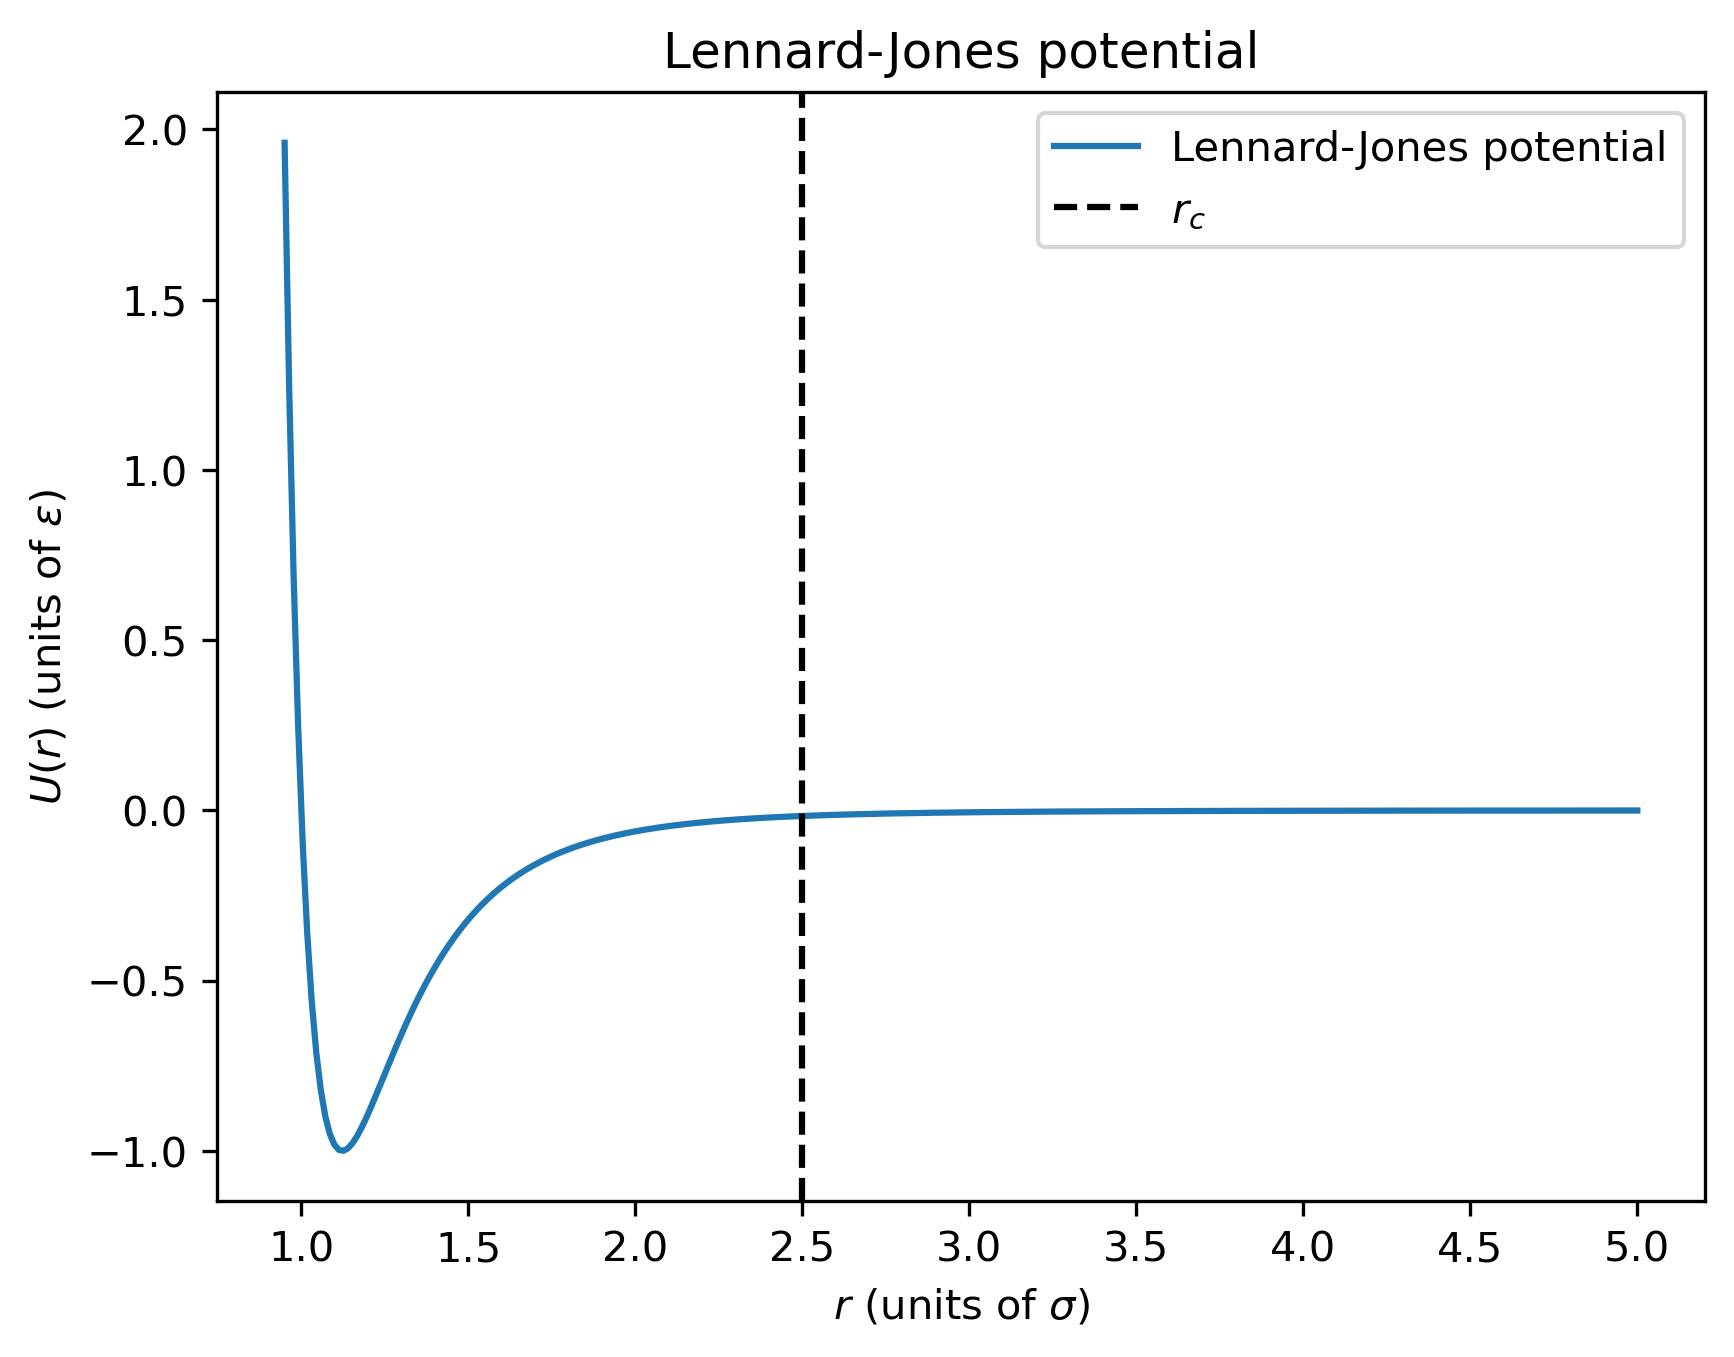

In [2]:
rc = 2.5 #cutoff distance

ULJ = lambda r: 4*(1/r**12 - 1/r**6) # Lennard-Jones potential


#plot the potential energy vs the distance, include a vertical line at the cutoff distance
r = np.linspace(0.95, 5, 300)

plt.plot(r, ULJ(r), label='Lennard-Jones potential')
plt.xlabel('$r$ (units of $\sigma$)',)
plt.ylabel('$U(r)$ (units of $\epsilon$)')
plt.axvline(rc, color='k', linestyle='--', label='$r_c$')
plt.legend()
plt.title('Lennard-Jones potential')

The term in $1/r^{12}$ captures short range **repulsive interactions** between the particles, whilst the term in $1/r^6$ captures long range attractive forces between the particles. There is a stable equilibrium corresponding to the minimum of $U_{LJ}$. You can read more about the LJ potential [here](https://lamma.engineering.unt.edu/sites/default/files/class5_handout_mtse_5010_2018.pdf).

## 2 Initial conditions
Let's initialize the variables we need for this simulation and set $\vec r(0)$ and $\vec v(0)$. This will pretty much be exactly the same than for the ideal gas video. 

In [3]:
#simulation variables
N = 100 # number of particles
radius = 0.3 # radius of particles
L = 10 # length of box
duration = 10  # duration of simulation
nsteps = 1500 # number of steps
dt = duration/nsteps  # time step
v0 = 1.5 # initial velocity magnitude


#initialize the postions of the particles in a grid
grid_size = int(np.ceil(np.sqrt(N))) # Create enough positions in grid for the particles
spacing = L/ grid_size 
x = np.linspace(radius + spacing/2, L - radius - spacing/2, grid_size) 
pos = list(product(x, x))
positions = np.array(pos[:N]) 

#initialize the velocities: random directions but fixed magnitude
theta = np.random.uniform(0, 2*np.pi, size=N)
vx,vy = v0*np.cos(theta), v0*np.sin(theta)
velocities = np.stack((vx,vy), axis=1)

(0.0, 10.0)

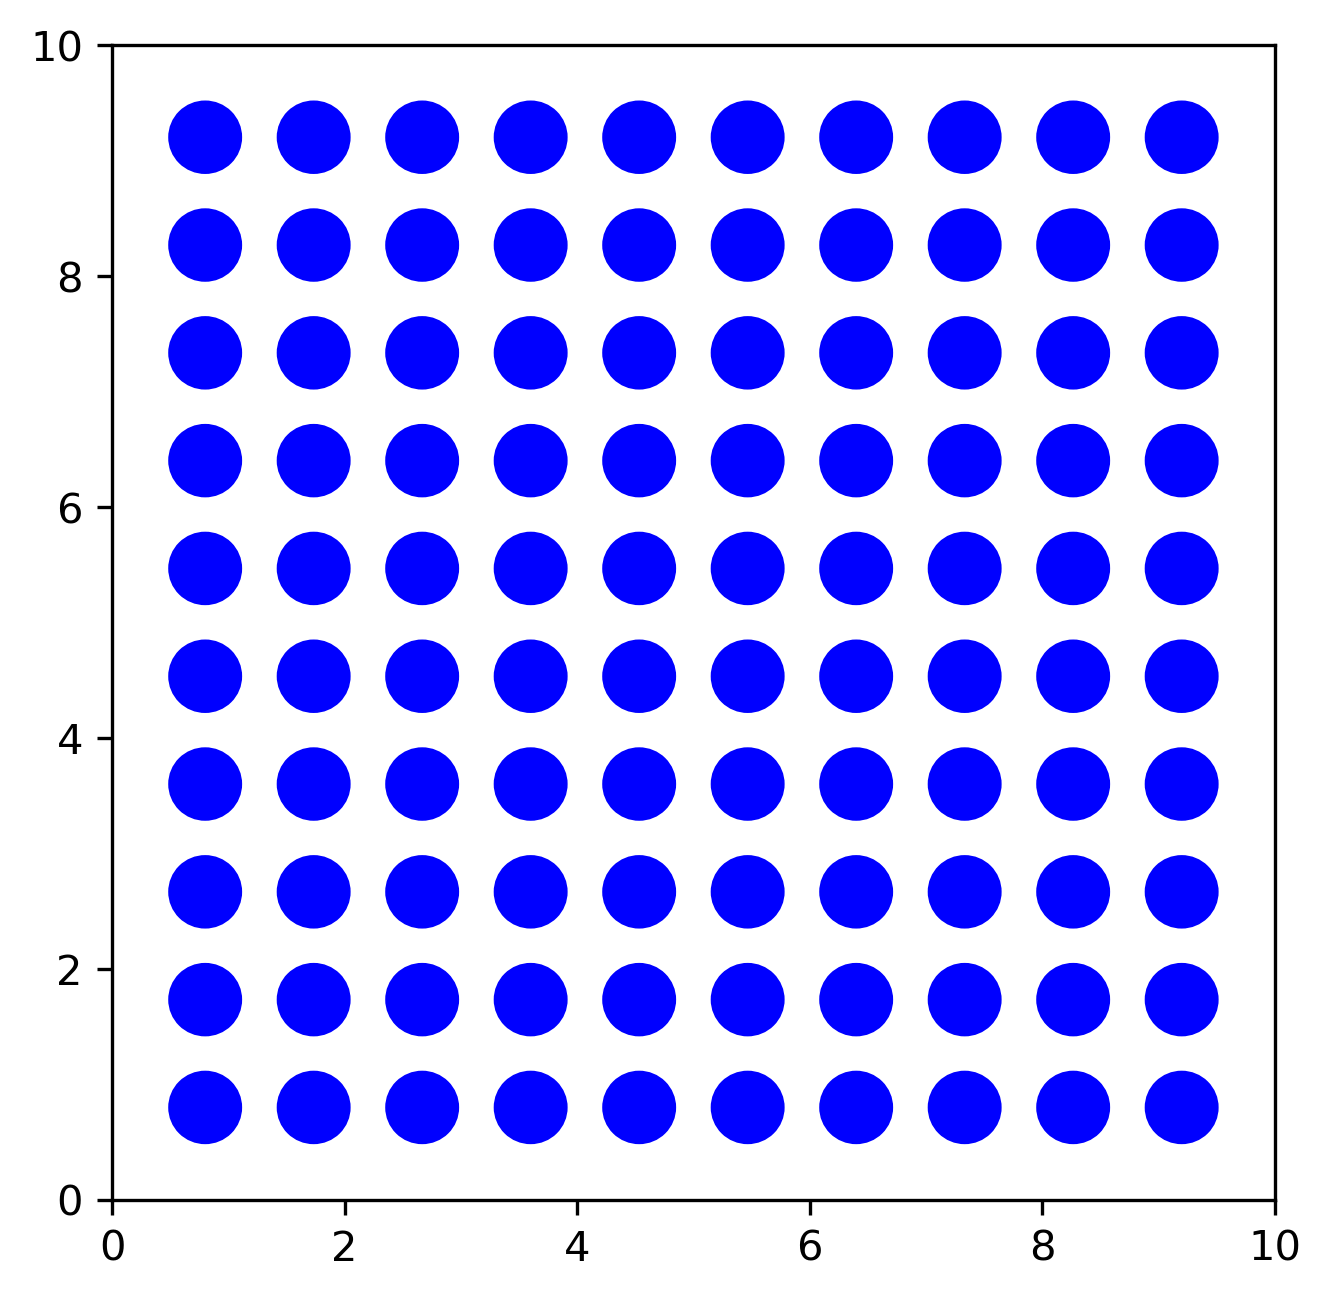

In [4]:
fig,ax = plt.subplots(figsize=(5,5))
for i in range(N):
    circle = plt.Circle((positions[i,0], positions[i,1]),radius, fill=True, color='blue') #plot the particle
    ax.add_artist(circle)

ax.set_xlim(0,L)
ax.set_ylim(0,L)

## 3. Resulting force 

The LJ potential induces a force that is proportional to the gradient of $U_{LJ}$: 

$$\vec F( \vec r)  = - \frac{\text{d} U_{LJ}}{\text{d} r} \vec u_r = \left(\frac{24}{r^7} -\frac{48}{r^{13}} \right) \frac{\vec r}{r} = \left(\frac{24}{r^8} -\frac{48}{r^{14}} \right) \vec r$$


This is the force that appears in the equations of motion for the particles. In this section, we're going to first write a function that gets the vector between two particles using periodic boundary conditions. Since we're simulating an infinite system, we need to choose the vector $\vec r = \vec r_2 - \vec r_1$ such that its norm is the smallest between all replicas of the box. 

Text(0, 0.5, '$y$ (units of $\\sigma$)')

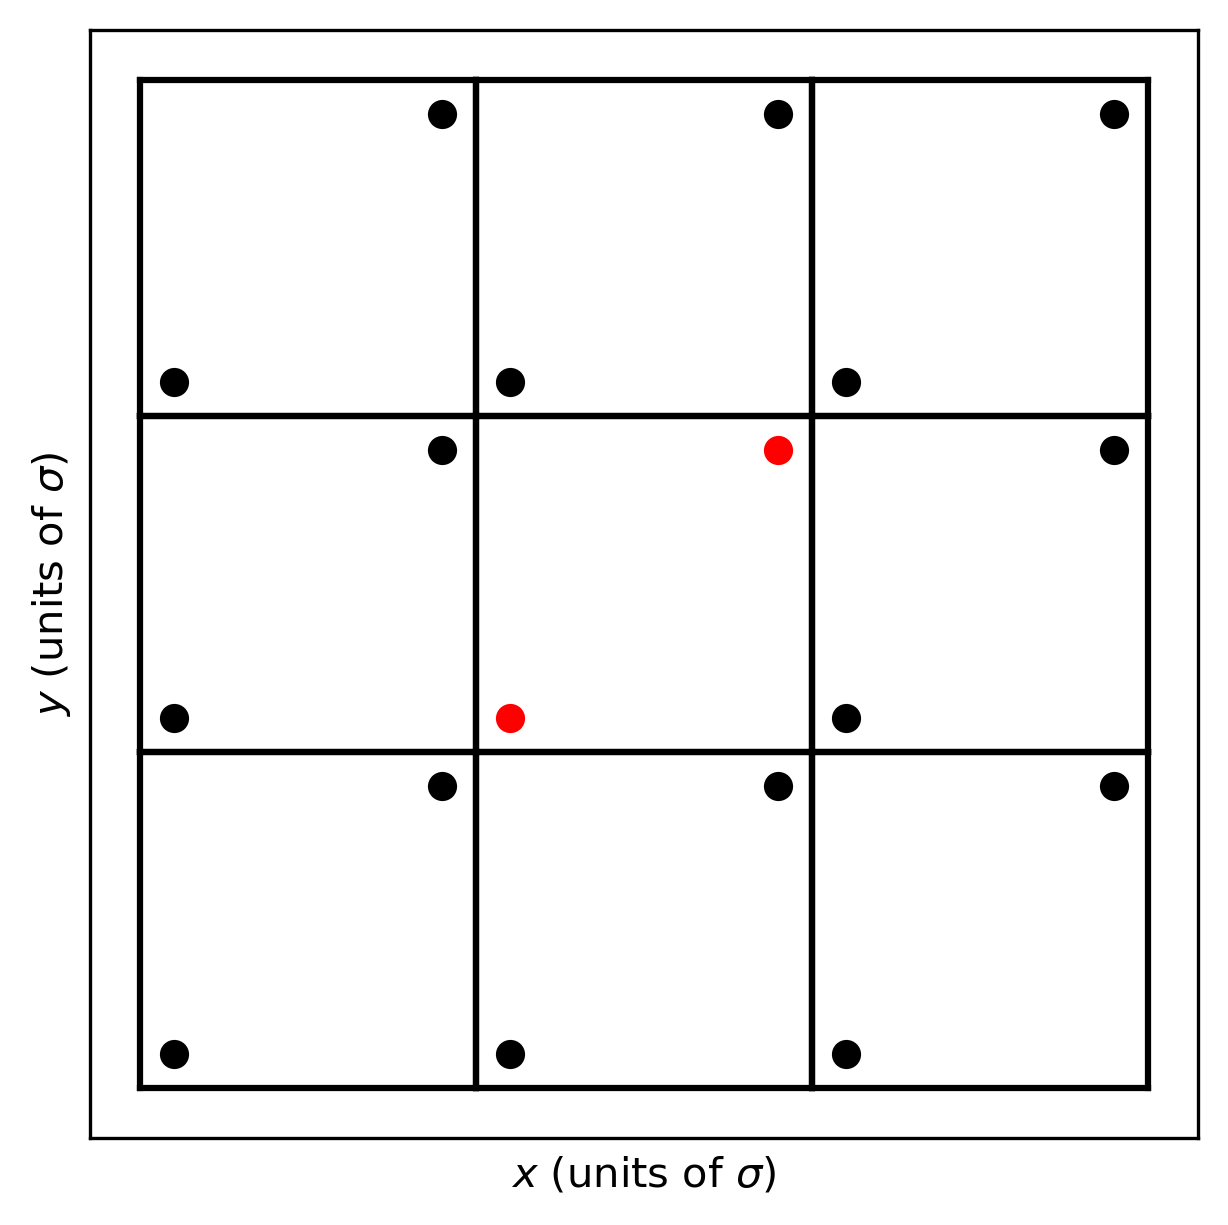

In [5]:
r1, r2 = np.array([0.9*L, 0.9*L]), np.array([0.1*L, 0.1*L]) #initialize two particles

for i in range(-1,2):
    for j in range(-1,2):
        if i == 0 and j == 0:
            plt.plot(r1[0]+i*L, r1[1]+j*L, 'ro')  # Plot in red
            plt.plot(r2[0]+i*L, r2[1]+j*L, 'ro')  # Plot in blue
        else:
            plt.plot(r1[0]+i*L, r1[1]+j*L, 'ko')  # Plot in black
            plt.plot(r2[0]+i*L, r2[1]+j*L, 'ko')  # Plot in black

        plt.plot([i*L, (i+1)*L], [j*L, j*L], 'k-')  # Horizontal side
        plt.plot([i*L, i*L], [j*L, (j+1)*L], 'k-')  # Vertical side
        plt.plot([(i+1)*L, (i+1)*L], [j*L, (j+1)*L], 'k-')  # Vertical side
        plt.plot([i*L, (i+1)*L], [(j+1)*L, (j+1)*L], 'k-')  # Horizontal side

plt.xticks([]) # Remove x-ticks
plt.yticks([]) # Remove y-ticks

plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('$x$ (units of $\sigma$)')
plt.ylabel('$y$ (units of $\sigma$)')

In [6]:
def pair_vector(r1,r2,L):
    """Calculate the vector r2 - r1 with periodic boundary conditions."""
    r = r2 - r1
    r -= np.rint(r / L) * L
    return r

Let's calculate the force acting on a particle due to another particle given their positions inside the box: $\vec r_1$, $\vec r_2.$ We need to make sure to cut the force off for $r > r_c$.

In [7]:
def force(r1,r2,L):
    """Calculate the force on particle 1 due to particle 2."""
    r = pair_vector(r1,r2,L) #calculate the vector between the particles
    r_mag = np.linalg.norm(r) #calculate the magnitude of the vector
    
    if r_mag < rc:
        return (-48/r_mag**14 + 24/r_mag**8) * r
    else:
        return np.zeros(2)

## 4. Equations of motion 

The equation of motion for particle $i$ at time $t$ is given by Newton's second law: 

$$m \ddot{ \vec r}_i = \sum_{j} \vec F_{j \to i}$$

Where the sum runs over all particles $j \neq i$ and $\vec F_{j \to i}$ is the force exerted on particle $i$ by particle $j.$ At every step of our simulation, we need to know what is the net force felt by all particles. Let's write a function which takes in the positions of our particles at a certain time and stores the force felt by each particle. To make things simple, we'll set $m = 1$.

To summarize, we need to implement the following to get the force felt by all the particles: 
* Loop through all particles $i$.
* Loop through all particles $j \neq i$.
* Calculate the force on $i$ due to all the other particles. 

We can be a little bit clever here: since we know that by Newton's third law, $\vec F_{j \to i} = - \vec F_{i \to j},$ we can do the second for loop for $j >i$, making the algorithm slightly more efficient. This step is actually the most expensive part of the simulation since we need to do $\mathcal{O}(N^2)$ operations at each step!

In [8]:
def get_forces(positions,L):
    """Calculate the forces on all particles."""
    forces = np.zeros_like(positions)
    for i in range(N):
        for j in range(i+1,N):
            r1,r2 = positions[i],positions[j]
            forces[i] += force(r1,r2,L)
            forces[j] -= force(r1,r2,L)
    return forces

## 5. Numerical integration
Now we need to find a way to perform a discrete integration of the equations of motion, that is, evolve the particles' positions and velocities from time $t \to t + \Delta t$. We'll use a popular molecular dynamics algorithm called the **velocity Verlet algorithm**. You can read more about it [here](https://tonypaxton.org/Notes/MD.pdf).

To see how this works, we can start by Taylor expanding $\vec r_i(t+ \Delta t)$ about $\Delta t$:
$$\vec r_i(t+ \Delta t) = \vec r_i(t) + \vec v_i(t) \Delta t + \frac {\Delta t^2}{2m} \sum_j \vec F_{j \to i} +\mathcal{O}(\Delta t^3) $$

This gives us the positions of the particles at time $t + \Delta t$ with an error of order $\Delta t^3$. To update the velocities, we use: 

$$\vec v_i(t + \Delta t) = \vec v_i(t) + \frac{\Delta t}2 \left( \vec a_i(t + \Delta t) + \vec a_i(t) \right)+ \mathcal{O}(\Delta t^2),$$

where $\vec a_i(t + \Delta t)$ is the acceleration vector of particle $i$ at time $t+ \Delta t$. This gives us the velocities of the particles at the next time step with an error of order $\Delta t^2$. 
In short, we need to do the following at each time step:
* Use the current positions and velocities $\vec r(t),$ $\vec v(t)$ to get the forces acting on the particles at time $t$.
* Implement the equation for $\vec r(t + \Delta t)$.
* Use the new positions to get the forces acting on the particles at time $t+ \Delta t$.
* Implement the equation for $\vec v(t+ \Delta t).$




In [9]:
def step(positions, velocities, L,dt): 
    
    forces = get_forces(positions, L)
    positions[:] = positions + velocities*dt + 0.5*forces*dt**2
    next_forces = get_forces(positions, L)
    velocities[:] = velocities + 0.5*(forces + next_forces)*dt
    return positions, velocities


## 6. That's it! Now it's time to run our simulation! 

In [10]:
def animate(positions, velocities, L, nsteps):


    all_positions = np.zeros((nsteps, N, 2)) #store all positions
    all_velocities = np.zeros_like(all_positions) #store all velocities

    for t in range(nsteps): #iterate over all steps
        all_positions[t] = positions #add to positions positions
        all_velocities[t] = velocities #add to velocities velocities
        positions, velocities = step(positions, velocities, L,dt) #step forward in time


    return all_positions, all_velocities



all_positions, all_velocities = animate(positions, velocities, L, nsteps)



## A few sanity checks

### Conservation of energy
It's always important to check that the results of a physics simulation are consistent with the laws of nature. For example, we expect that the mechanical energy of the system $E = K+U$ should be conserved since the force from the LJ potential is **conservative**. 

In [11]:

#compute the total potential energy at each step
potential_energy = np.zeros(nsteps)
for i in range(nsteps):
    for j in range(N):
        for k in range(j+1,N):
            r = pair_vector(all_positions[i,j],all_positions[i,k],L)
            r_mag = np.linalg.norm(r)
            if r_mag < rc:
                potential_energy[i] += ULJ(r_mag)


#compute the total kinetic energy at each step
kinetic_energy = 0.5 * np.sum(np.linalg.norm(all_velocities, axis=2)**2,axis=1)


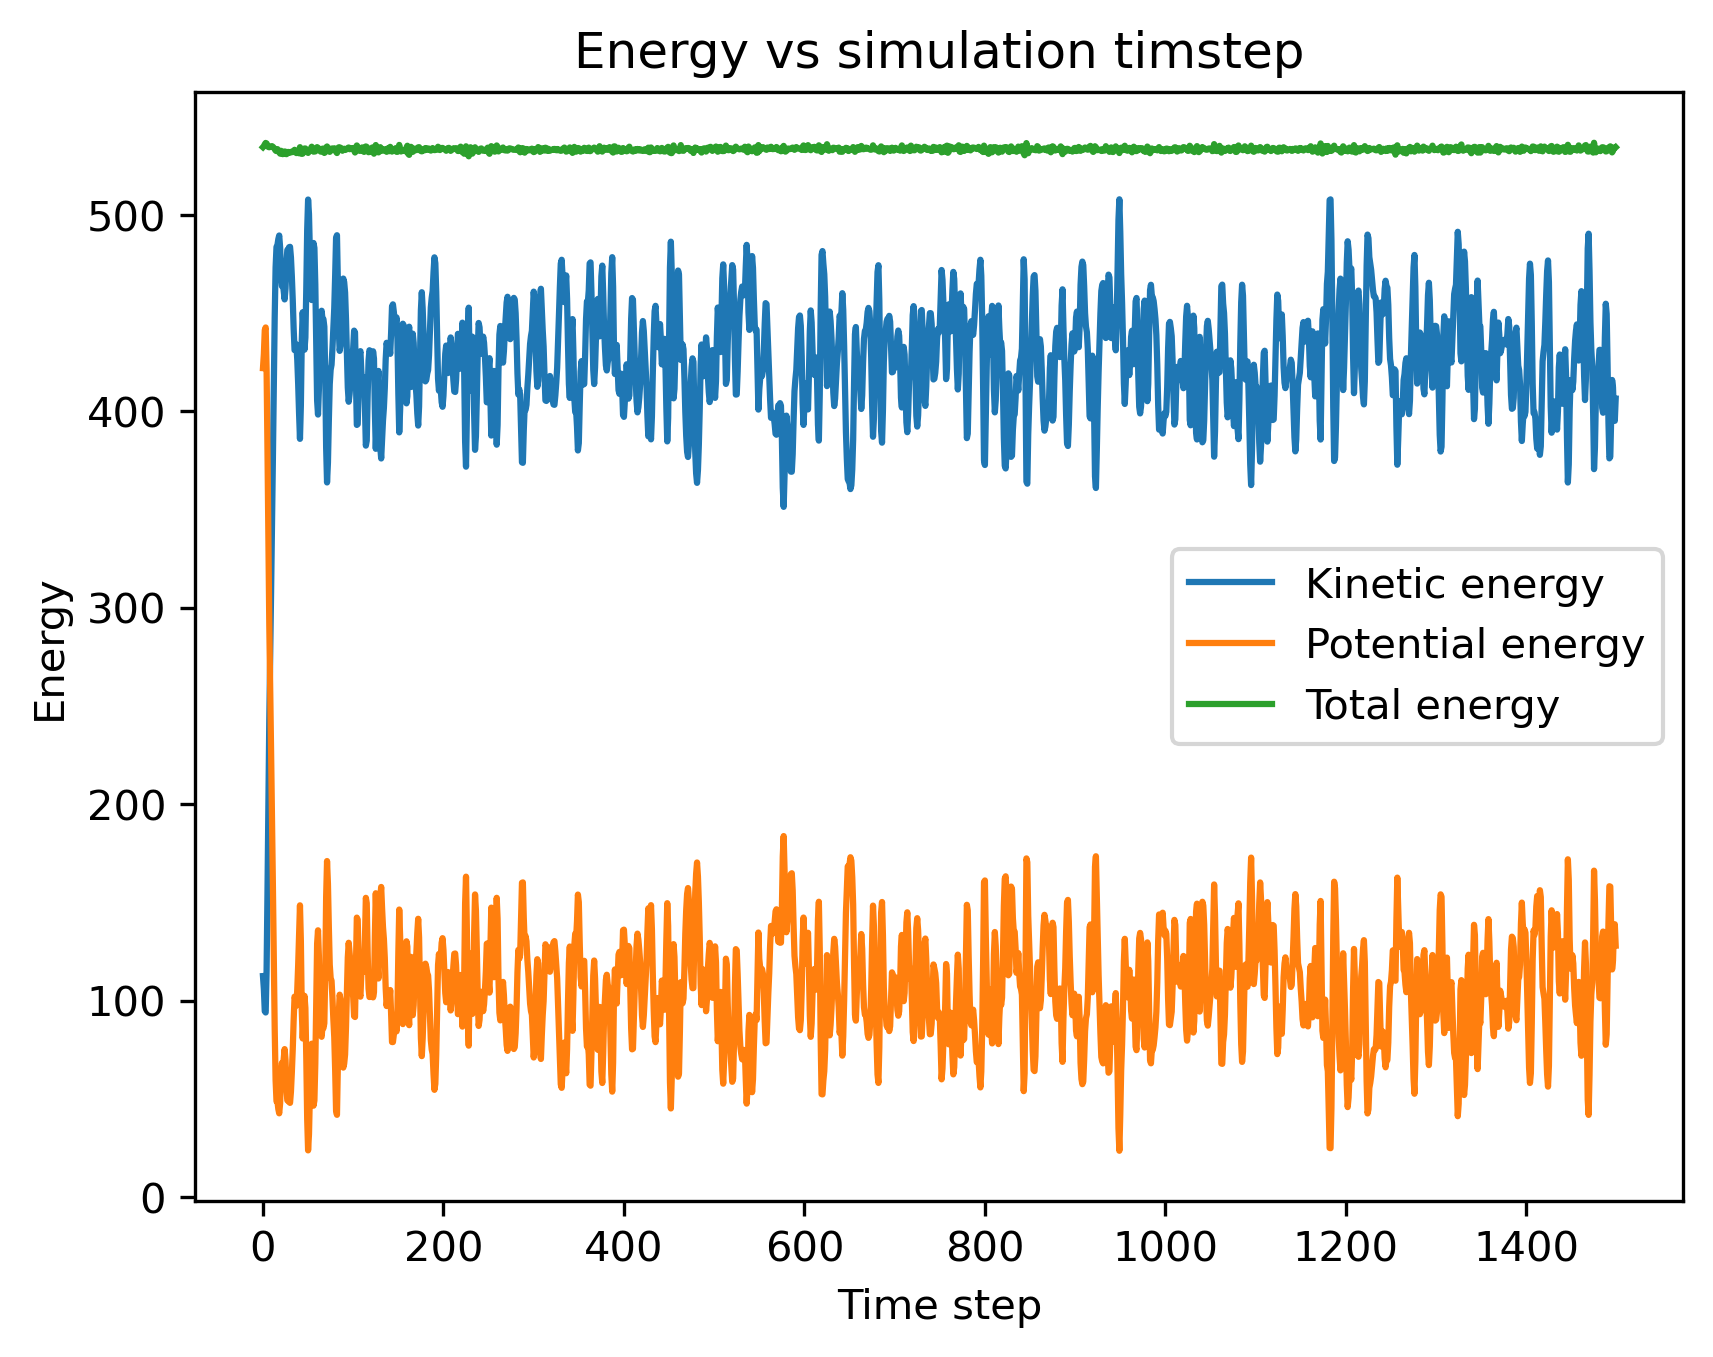

In [12]:
plt.plot(np.arange(nsteps), kinetic_energy, label = 'Kinetic energy')
plt.plot(np.arange(nsteps), potential_energy, label = 'Potential energy')
plt.plot(np.arange(nsteps), kinetic_energy + potential_energy, label = 'Total energy')
plt.xlabel('Time step')
plt.ylabel('Energy')
plt.title('Energy vs simulation timstep')
plt.legend()

## Checking the equilibrium velocity distribution
Once our system thermalizes, we expect the velocity distribution to follow the 2D Maxwell-Boltzmann distribution:
$$f(v) = \frac{mv}{k_BT} e^{-\frac{mv^2}{2k_B T}},$$

Where $k_B T$ is the average kinetic energy per particle.
 Let' explicitly check this.

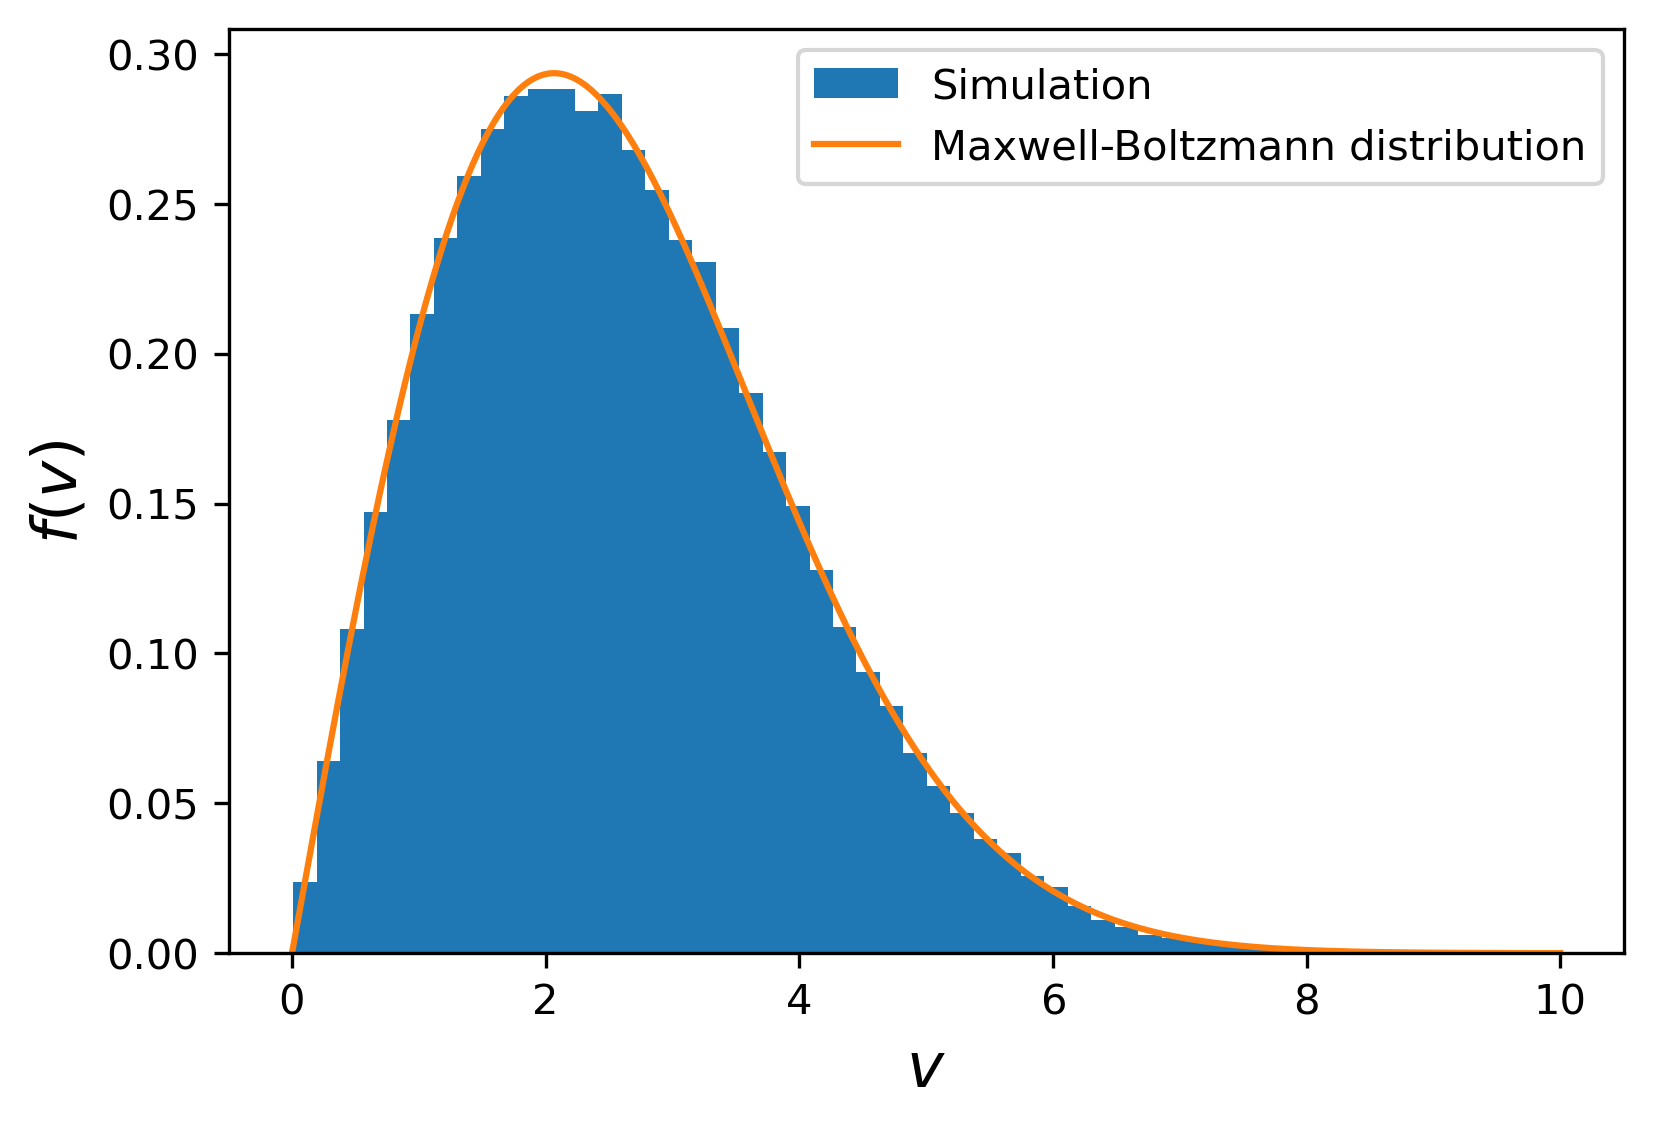

In [13]:
kT = np.mean(kinetic_energy[200:])/N #average kinetic energy per particle after the system has reached equilibrium

mb_dist = lambda v: v/kT * np.exp(-v**2/(2*kT)) # Maxwell-Boltzmann distribution

speeds = np.linalg.norm(all_velocities, axis=2)
v = np.linspace(0,10,500)

plt.figure(figsize=(6,4))
plt.hist(speeds[200:].flatten(), bins=50, density=True, label='Simulation')
plt.plot(v, mb_dist(v), label='Maxwell-Boltzmann distribution')
plt.xlabel('$v$', fontsize=15)
plt.ylabel('$f(v)$', fontsize=15)
plt.legend()

## Animation with varying colors to show the speeds of the particles

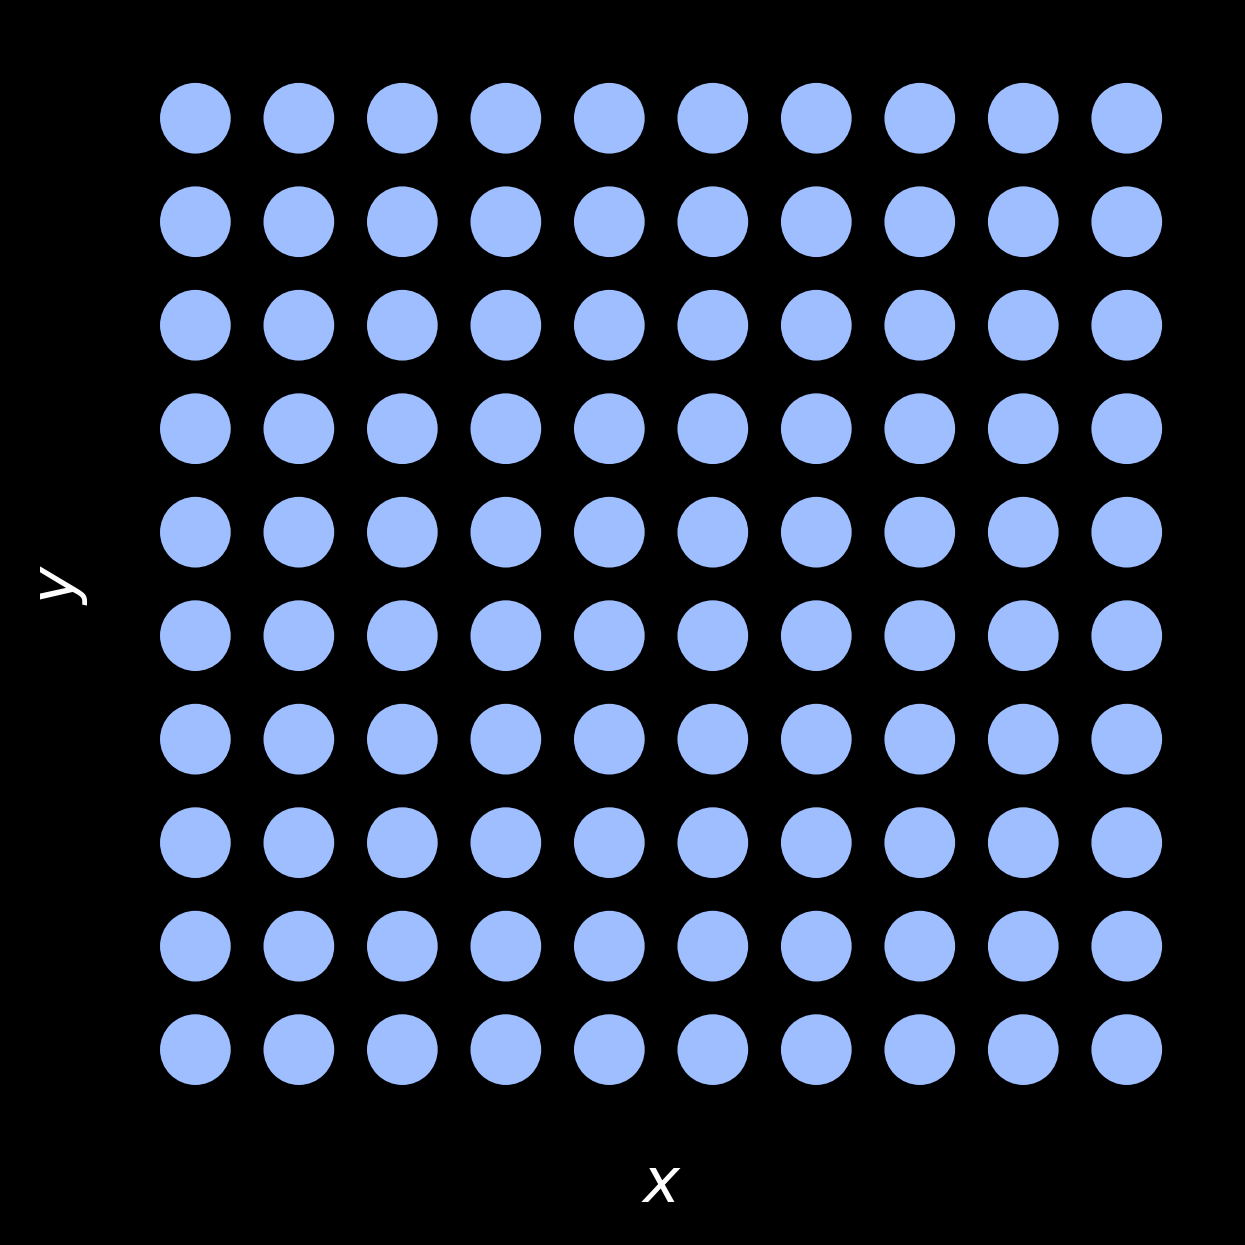

In [14]:
normalized_speeds = speeds/5 
fig,ax = plt.subplots()

# Set the background color to black
fig.patch.set_facecolor('black')

def animate_positions(t):

    ax.clear()
    ax.set_facecolor('black')
    for i in range(N): #plot all the particles 

        x, y = (all_positions[t,i, 0])%L, (all_positions[t, i, 1])%L #Get the x and y positions of the particle modulo L

        color = plt.cm.coolwarm(normalized_speeds[t,i]) #color the particle by its speed
        circle = plt.Circle((x, y),radius, fill=True, color=color) #plot the particle
        ax.add_artist(circle)


    ax.set_xlabel('$x$', fontsize=15, color='white')
    ax.set_ylabel('$y$', fontsize=15, color='white')
    ax.set_xlim(0, L)
    ax.set_ylim(0, L)
    ax.set_aspect('equal')
    ax.set_xticks([]) #remove ticks
    ax.set_yticks([])

interval = duration*1e3/nsteps
ani = animation.FuncAnimation(fig, animate_positions, frames=nsteps, interval=interval)
ani.save('lennard_jones_simulation.mp4', writer='ffmpeg')


In [ ]:
fig,ax = plt.subplots(figsize=(9,16))

# Set the background color to black
fig.patch.set_facecolor('black')

def animate_positions(t):

    ax.clear()
    ax.set_facecolor('black')
    for i in range(N): #plot all the particles 

        x, y = (all_positions[t,i, 0])%L, (all_positions[t, i, 1])%L #Get the x and y positions of the particle modulo L

        color = plt.cm.coolwarm(normalized_speeds[t,i]) #color the particle by its speed
        circle = plt.Circle((x, y),radius, fill=True, color=color) #plot the particle
        ax.add_artist(circle)


    ax.set_xlabel('$x$', fontsize=15, color='white')
    ax.set_ylabel('$y$', fontsize=15, color='white')
    ax.set_xlim(0, L)
    ax.set_ylim(0, L)
    ax.set_aspect('equal')
    ax.set_xticks([]) #remove ticks
    ax.set_yticks([])

interval = duration*1e3/nsteps
ani = animation.FuncAnimation(fig, animate_positions, frames=nsteps, interval=interval)
ani.save('lennard_jones_short.mp4', writer='ffmpeg')
